In [34]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [35]:
# Load the data
stocks_title = ['CTG_dropna.csv', 'GAS_dropna.csv', 'HPG_dropna.csv', 'PLX_dropna.csv']
data = pd.read_csv(stocks_title[1], parse_dates=True, index_col='Date')
data = data[["Close"]]


number_of_rows = len(data.index)
print(f"Number of rows: {number_of_rows}")

Number of rows: 2995


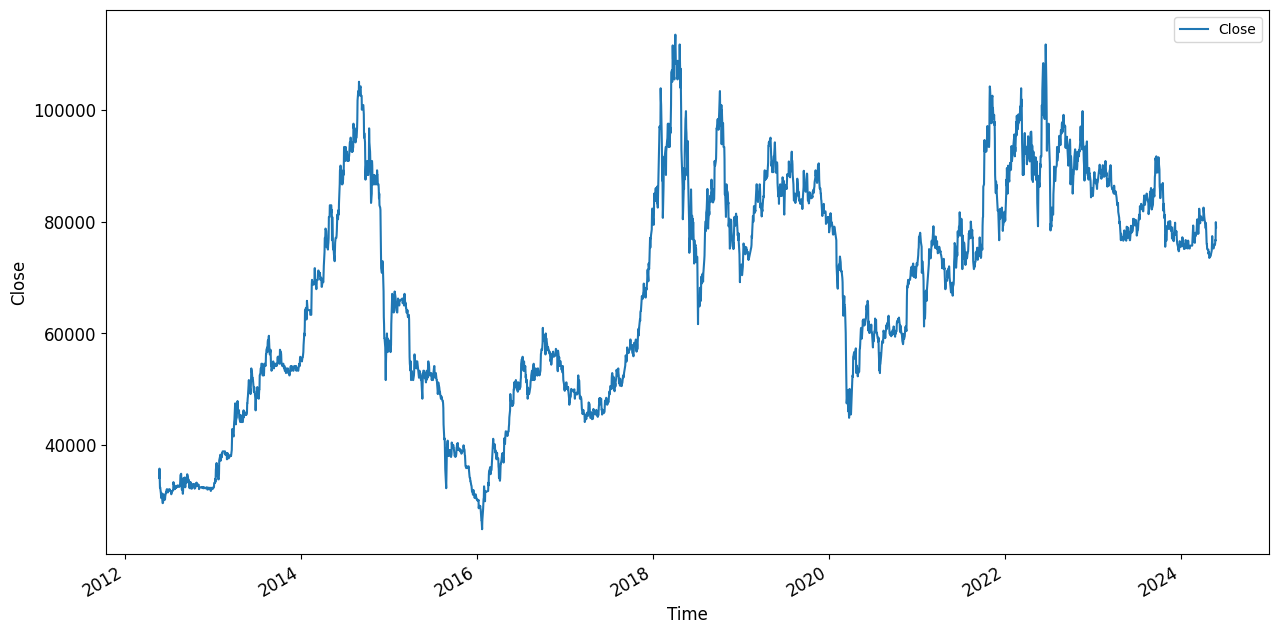

In [36]:
data.plot(y='Close', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.show()

In [37]:
# Split the data into a training set and a test set (80% training and 20% testing)
data_train = data.copy()[:int(number_of_rows*0.8)]
data_test = data.copy()[int(number_of_rows*0.8):]
print("Number of rows in training set: ", len(data_train.index))
print("Number of rows in test set: ", len(data_test.index))

Number of rows in training set:  2396
Number of rows in test set:  599


In [38]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data_train_scaled = scaler.fit_transform(data_train)
data_train["Close_scaled"] = data_train_scaled
data_test_scaled = scaler.transform(data_test)
data_test["Close_scaled"] = data_test_scaled

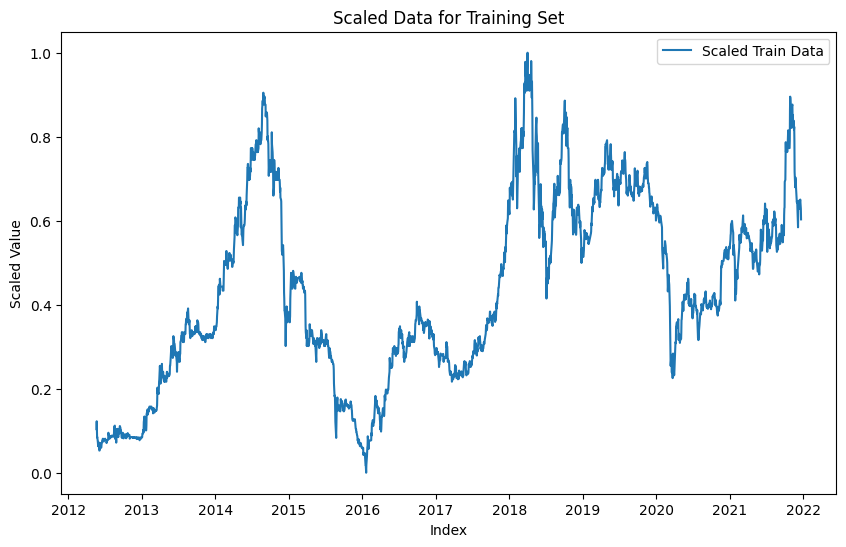

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(data_train["Close_scaled"], label='Scaled Train Data')
plt.xlabel('Index')
plt.ylabel('Scaled Value')
plt.title('Scaled Data for Training Set')
plt.legend()
plt.show()

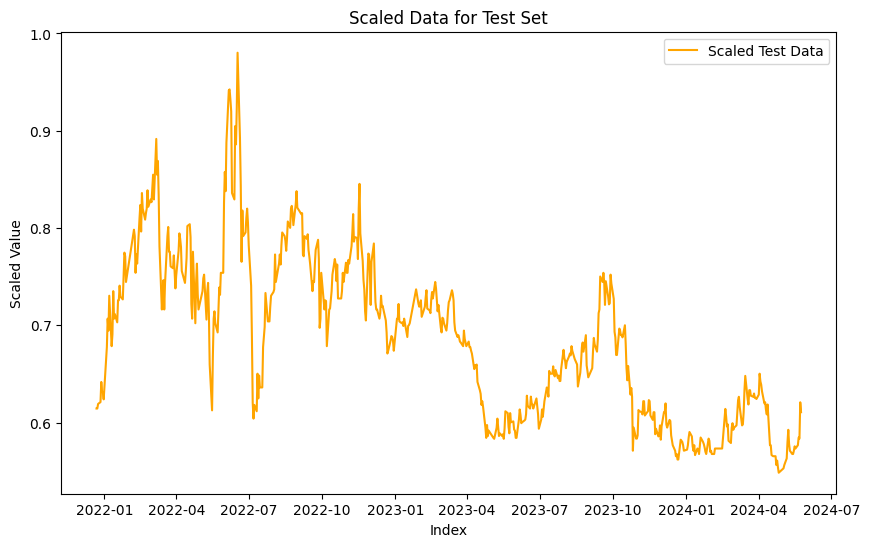

In [40]:
# Plot the scaled data for the test set
plt.figure(figsize=(10, 6))
plt.plot(data_test["Close_scaled"], label='Scaled Test Data', color='orange')
plt.xlabel('Index')
plt.ylabel('Scaled Value')
plt.title('Scaled Data for Test Set')
plt.legend()
plt.show()

# Tests for Stationarity
A time series is stationary if the mean and variance are fixed between any two equidistant points. That is, no matter where you take your observations, the results should be the same. A times series that shows seasonality is not stationary.

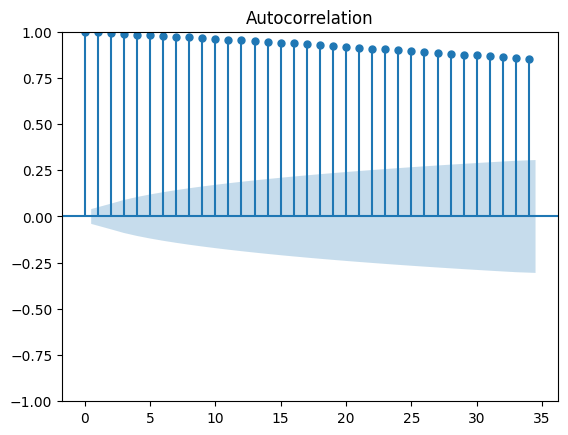

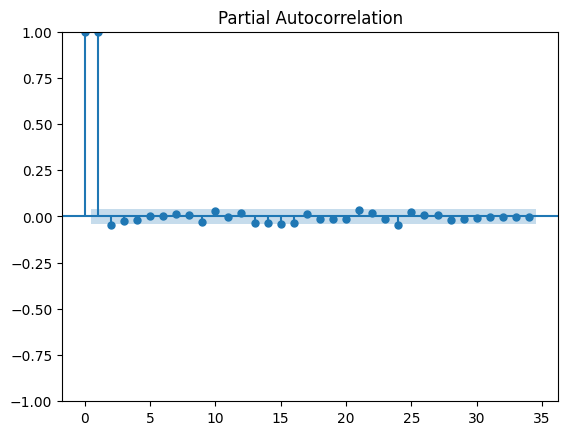

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_train["Close_scaled"])
# The function calculates the partial autocorrelation by the Yule-Walker equations
plot_pacf(data_train["Close_scaled"]);

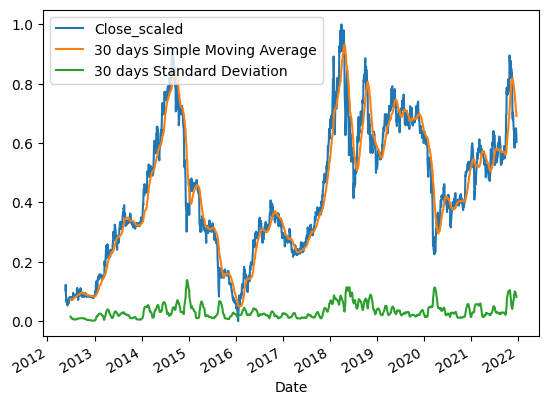

In [42]:
rolling_window = 30
data_train[f'{rolling_window} days Simple Moving Average'] = data_train['Close_scaled'].rolling(window=rolling_window).mean()
data_train[f'{rolling_window} days Standard Deviation'] = data_train['Close_scaled'].rolling(window=rolling_window).std()

data_train[['Close_scaled',f'{rolling_window} days Simple Moving Average',f'{rolling_window} days Standard Deviation']].plot();

In [43]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','Number of lags used','Number of observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
        return True
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        return False

# Differencing the data
This make the data stationary


In [44]:
def difference_data(series):
    series_dif = series.diff().dropna()
    return series_dif

# Performing a grid search
This process help us to decide which is the suitable arima parameters (p, d, q) base on the AIC (Akaike Information Criterion)


In [45]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np


def grid_search_arima(data, p_values, d_values, q_values):
    best_aic = np.inf
    best_order = None
    best_model = None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                model = ARIMA(data, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
    return best_order, best_model



# Fit and the training set and forcast in the test set

In [46]:
def best_order(train_data, p_values, q_values):
    """
    Fit the ARIMA model to the training data and forecast the testing data.
    """
    # Determine if the data is stationary
    is_stationary = adf_test(train_data, title='Training Data ADF Test')

    d = 0
    if not is_stationary:
        print("Differencing the data to make it stationary")
        train_data = difference_data(train_data)
        d = 1
        while not adf_test(train_data, title=f'Training Data ADF Test after {d} differencing'):
            train_data = difference_data(train_data)
            d += 1

    # Find the suitable ARIMA model using grid search
    best_order, best_model = grid_search_arima(train_data, p_values, [d], q_values)
    print(f'Suitable ARIMA order: {best_order}')
    return best_order

In [47]:
p_values = range(0,4)
q_values = range(0,4)
order = best_order(data_train['Close_scaled'], p_values, q_values)

Augmented Dickey-Fuller Test: Training Data ADF Test
ADF test statistic          -2.149090
p-value                      0.225238
Number of lags used          1.000000
Number of observations    2394.000000
critical value (1%)         -3.433084
critical value (5%)         -2.862748
critical value (10%)        -2.567413
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Differencing the data to make it stationary
Augmented Dickey-Fuller Test: Training Data ADF Test after 1 differencing
ADF test statistic         -46.213771
p-value                      0.000000
Number of lags used          0.000000
Number of observations    2394.000000
critical value (1%)         -3.433084
critical value (5%)         -2.862748
critical value (10%)        -2.567413
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Suitable ARIMA order: (1, 1, 1)


In [48]:
window = 30

# Prepare data for walk-forward validation
train_data = data_train['Close_scaled'].values
test_data = data_test['Close_scaled'].values

# Initialize history with the first 30 days from the training data
history = [x for x in data_train['Close_scaled'].values[:window]]

# Prepare list to store predictions
train_predictions = []

# Perform walk-forward validation
for i in range(window, len(train_data)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)
    train_predictions.append(output[0])
    # Update history with the actual observation
    history.append(train_data[i])
    history.pop(0)



In [49]:
# Predicting but with a condition that we have to update the actual observation
test_predictions = []

for i in range(len(data_test)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)
    test_predictions.append(output[0])
    history.append(test_data[i])
    history.pop(0)



# Rescale

In [50]:
# Rescale the predictions back to the original scale
train_predictions_rescaled = scaler.inverse_transform(np.array(train_predictions).reshape(-1, 1)).flatten()
test_predictions_rescaled = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
data_train_rescaled = scaler.inverse_transform(data_train['Close_scaled'].values.reshape(-1, 1)).flatten()
data_test_rescaled = scaler.inverse_transform(data_test['Close_scaled'].values.reshape(-1, 1)).flatten()

# Plotting

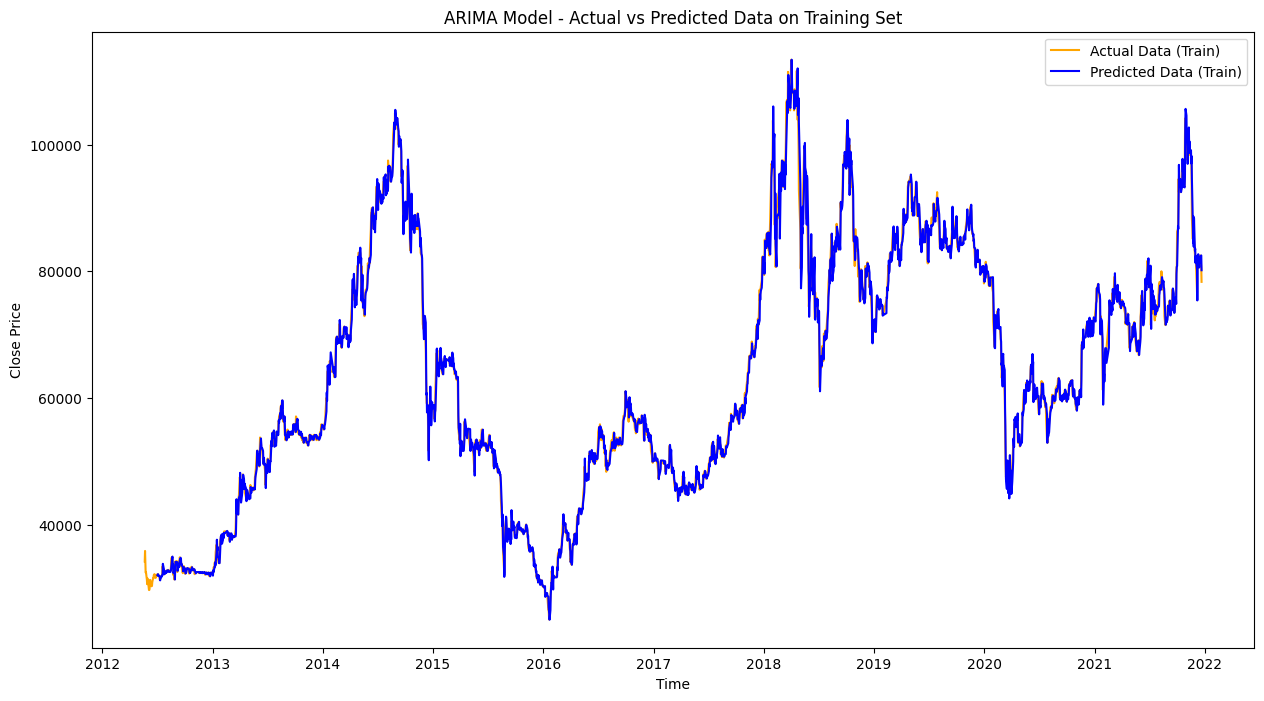

In [51]:
# Plot the actual and predicted values for the training set
plt.figure(figsize=(15, 8))
plt.plot(data_train.index, data_train_rescaled, label='Actual Data (Train)', color='orange')
plt.plot(data_train.index[window:], train_predictions_rescaled, label='Predicted Data (Train)', color='blue')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('ARIMA Model - Actual vs Predicted Data on Training Set')
plt.legend()
plt.show()

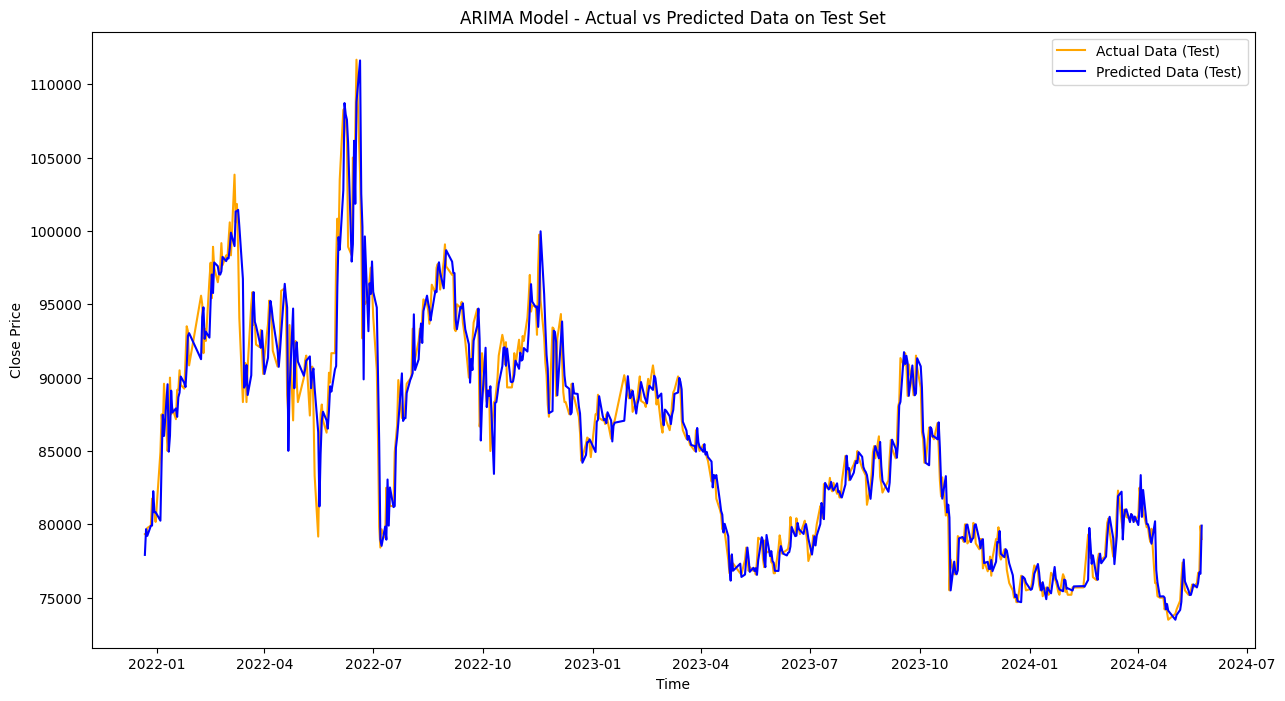

In [52]:
# Plot the actual and predicted values for the test set
plt.figure(figsize=(15, 8))
plt.plot(data_test.index, data_test_rescaled, label='Actual Data (Test)', color='orange')
plt.plot(data_test.index, test_predictions_rescaled, label='Predicted Data (Test)', color='blue')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('ARIMA Model - Actual vs Predicted Data on Test Set')
plt.legend()
plt.show()

# Model Evaluation

In [53]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Calculate performance metrics on the training set
rmse_train = np.sqrt(mean_squared_error(data_train_rescaled[window:], train_predictions_rescaled))
mape_train = mean_absolute_percentage_error(data_train_rescaled[window:], train_predictions_rescaled)


print(f'Root Mean Squared Error (RMSE) on Training Set: {rmse_train}')
print(f'Mean Absolute Percentage Error (MAPE) on Training Set: {mape_train}')


# Calculate performance metrics on the test set
rmse_test = np.sqrt(mean_squared_error(data_test_rescaled, test_predictions_rescaled))
mape_test = mean_absolute_percentage_error(data_test_rescaled, test_predictions_rescaled)


print(f'Root Mean Squared Error (RMSE) on Test Set: {rmse_test}')
print(f'Mean Absolute Percentage Error (MAPE) on Test Set: {mape_test}')


Root Mean Squared Error (RMSE) on Training Set: 1579.318954650833
Mean Absolute Percentage Error (MAPE) on Training Set: 0.016159321828078426
Root Mean Squared Error (RMSE) on Test Set: 1879.7830377558969
Mean Absolute Percentage Error (MAPE) on Test Set: 0.014440877766290695
